# GLM Demo: multivariate song stimulus, CRCNS neurons

This notebook demonstrates fitting to a real neuron from the CRCNS dataset.

In [1]:
from __future__ import print_function, division
import os
import sys
import imp
import numpy as np
import adaptivekde as adk

import mat_neuron._model as mat
from dstrf import io, strf, mle, simulate, data, filters, models, spikes, performance

# plotting packages
%reload_ext yamlmagic
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

cfg = {}

In [2]:
%%yaml cfg
model:
  dt: 0.5
  ataus: [10.0, 200.0]
  t_refract: 2.0
  filter:
    rank: 2
    len: 50
    ncos: 12
  prior:
    l1: 585.0558005127248
    l2: 30.792410553301334
data:
  source: "crcns"
  root: "../../crcns"
  cell: "publu0717_2_B"
  stimulus:
    stim_type: "conspecific"
    spectrogram:
      window: 2.5
      compress: 1
      f_min: 1.0
      f_max: 8.0
      f_count: 20
      gammatone: True
  prepadding: 50.0
  dt: 1.0
  test_proportion: 0.2
spike_detect:
  thresh: -20.0
  rise_dt: 1.0
emcee:
  nsteps: 10
  nthreads: 8
  nwalkers: 500
  startpos_scale: 2.0
  bounds:
  - [0, 20]
  - [-50, 200]
  - [-5, 10]  

<IPython.core.display.Javascript object>

In [3]:
from munch import munchify
cf = munchify(cfg)

In [4]:
imp.reload(data)
raw_data = data.crcns(cf)
n_test = int(cf.data.test_proportion * len(raw_data))
assim_data = io.merge_data(raw_data[:-n_test])

In [5]:
psth_dt = 5
upsample = int(psth_dt / cf.model.dt)   
eo = performance.corrcoef(assim_data["spike_v"][::2], assim_data["spike_v"][1::2], upsample, 1)

print("duration:", assim_data["duration"])
print("stim bins:", assim_data["stim"].shape[1])
print("spike bins:", assim_data["spike_v"].shape[0])
print("total spikes:", np.sum(assim_data["spike_v"]))
print("avg spike rate:", 1000 * np.sum(assim_data["spike_v"]) / assim_data["duration"] / assim_data["spike_v"].shape[1])
print("EO cc: %3.3f" % eo)

duration: 34726.0
stim bins: 34726
spike bins: 69452
total spikes: 2059
avg spike rate: 5.929274894891436
EO cc: 0.645


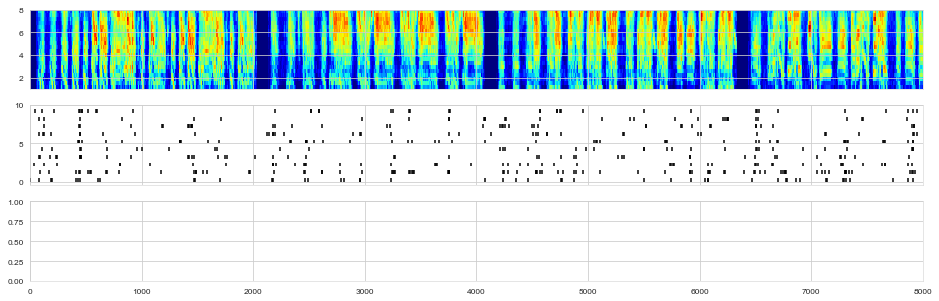

In [6]:
t_stim = np.linspace(0, assim_data["duration"], assim_data["stim"].shape[1])
t_spike = np.linspace(0, assim_data["duration"], assim_data["spike_v"].shape[0])

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(16, 5))
axes[0].imshow(assim_data["stim"], 
               extent=(0, assim_data["duration"], cf.data.stimulus.spectrogram.f_min, cf.data.stimulus.spectrogram.f_max),
               cmap='jet', origin='lower', aspect='auto')
for i, spk in enumerate(assim_data["spike_t"]):
    axes[1].vlines(spk * cf.model.dt, i, i + 0.5)

#assim_rate = adk.ssvkernel(np.concatenate(assim_data["spike_t"]), t_spike, nbs=0)[0]
# assim_rate, tt = adk.ssvkernel(assim_data["spike_t"][0] * cf.model.dt, t_spike, nbs=0)[0:2]
# axes[2].plot(tt, assim_rate)
    
axes[0].set_xlim(0, 8000);

## Estimate parameters

In [7]:
# initial guess of parameters using ML
krank = cf.model.filter.rank
kcosbas = strf.cosbasis(cf.model.filter.len, cf.model.filter.ncos)
try:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"])
except TypeError:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"])

In [9]:
%%time
nparams = 1 + mlest.n_hparams + mlest.n_kparams
constraint = models.matconstraint(nparams, cf.model.ataus[0], cf.model.ataus[1], cf.model.t_refract)
w0 = mlest.estimate(reg_lambda=cf.model.prior.l2, reg_alpha=cf.model.prior.l1, 
                    method='trust-constr', constraints=[constraint],
                    gtol=1e-2)

CPU times: user 1min 46s, sys: 10.1 s, total: 1min 56s
Wall time: 1min 44s


In [20]:
%time w0 = mlest.estimate(reg_lambda=cf.model.prior.l2, reg_alpha=cf.model.prior.l1)

/Users/dmeliza/Documents/projects/dstrf/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:621: OptimizeWarning: Unknown solver options: verbose
  callback=callback, **options)


CPU times: user 20.4 s, sys: 2.46 s, total: 22.9 s
Wall time: 21.3 s


In [ ]:
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(6, 3))
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], cf.data.stimulus.spectrogram.f_count, krank), kcosbas)
axes[0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[0].set_title("STA")
axes[1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1].set_title("MLE (rank-{})".format(krank));

## Predict responses

In [28]:
# test_data = io.merge_data(raw_data[:-n_test])
test_data = io.merge_data(raw_data[-n_test:])
mltest = mle.matfact(test_data["stim"], kcosbas, krank, test_data["spike_v"], test_data["spike_h"],
                     test_data["stim_dt"], test_data["spike_dt"])

In [29]:
print("duration:", test_data["duration"])
print("stim bins:", test_data["stim"].shape[1])
print("spike bins:", test_data["spike_v"].shape[0])
print("total spikes:", np.sum(test_data["spike_v"]))
print("avg spike rate:", 1000 * np.sum(assim_data["spike_v"]) / assim_data["duration"] / assim_data["spike_v"].shape[1])

duration: 8020.0
stim bins: 8020
spike bins: 16040
total spikes: 523
avg spike rate: 8.084546678086381


EO cc: 0.871
pred cc: 0.291
log-likelihood: 2780.919397
spike count: data = 523, pred = 494


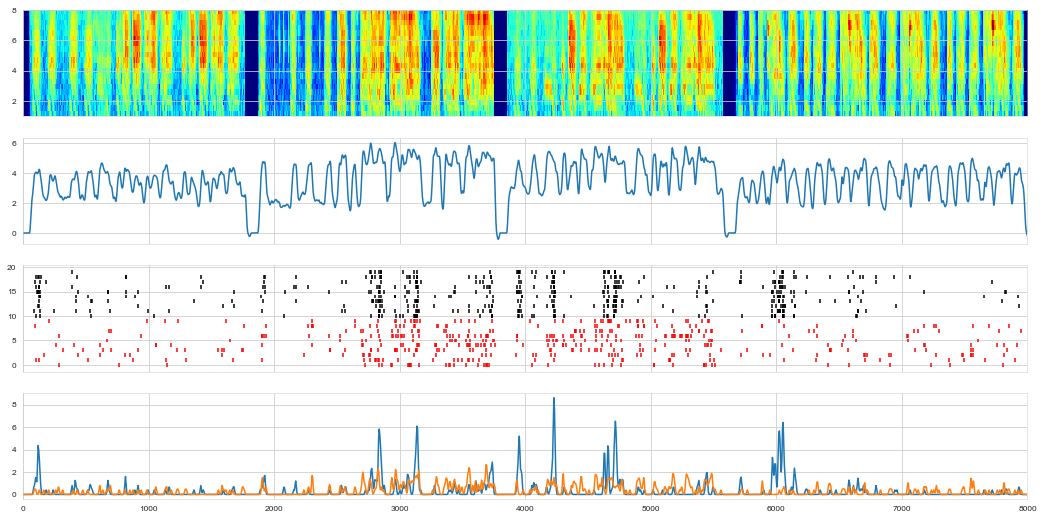

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(18, 9))
axes[0].imshow(test_data["stim"], 
               extent=(0, test_data["duration"], cf.data.stimulus.spectrogram.f_min, cf.data.stimulus.spectrogram.f_max),
               cmap='jet', origin='lower', aspect='auto')

t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
t_spike = np.linspace(0, test_data["duration"], test_data["spike_v"].shape[0])

Vpred = mltest.V(w0)
axes[1].plot(t_stim, Vpred)

n_trials = test_data["ntrials"]
for i, spk in enumerate(test_data["spike_t"]):
    axes[2].vlines(spk * cf.model.dt, i - 0.4 + n_trials, i + 0.4 + n_trials)
pred = np.zeros_like(test_data["spike_v"])
for j in range(n_trials):
    pred[:, j] = models.predict_spikes_glm(Vpred, w0[:3], cf)
    spk_t = pred[:, j].nonzero()[0]
    axes[2].vlines(spk_t * cf.model.dt, j - 0.4, j + 0.4, color='r')

psth_dt = 5
upsample = int(psth_dt / cf.model.dt)   
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
t_psth = np.linspace(0, test_data["duration"], test_psth.size)
axes[3].plot(t_psth, test_psth, t_psth, pred_psth)
axes[3].set_xlim(0, 8000);

eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
cc = performance.corrcoef(test_data["spike_v"], pred, upsample, 1)
print("EO cc: %3.3f" % eo)
print("pred cc: %3.3f" % cc)
print("log-likelihood: %f" % mltest.loglike(w0))
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum(), pred.sum()))